# Multi-dimensional interpolation example for O$_2$sclpy

See the O$_2$sclpy documentation at https://awsteiner.org/code/o2sclpy for more information.

In [6]:
import o2sclpy
import matplotlib.pyplot as plot
import random
import numpy
import sys
from IPython.utils import io

plots=True
if 'pytest' in sys.modules:
    plots=False

Link the O$_2$scl library:

In [7]:
link=o2sclpy.linker()
link.link_o2scl()

Create the data set:

In [8]:
ug=o2sclpy.uniform_grid_end.init(link,0,2,49)
t3d=o2sclpy.table3d(link)
t3d.set_xy_grid("x",ug,"y",ug)
t3d.new_slice("z")
for i in range(0,t3d.get_nx()):
    for j in range(0,t3d.get_ny()):
        x=t3d.get_grid_x(i)
        y=t3d.get_grid_y(j)
        r=numpy.sqrt(x**2+y**2)+numpy.cos(x*4)-y
        t3d.set(i,j,"z",numpy.sin(r*5))

Make a density plot of the original data set:

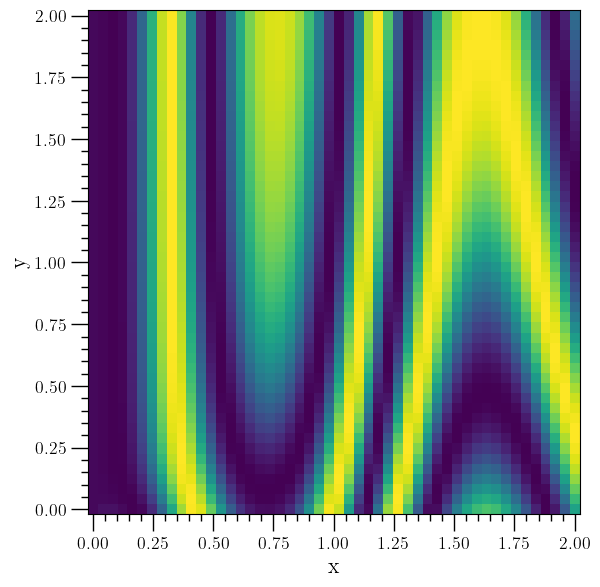

In [9]:
if plots:
    pl=o2sclpy.plot_base()
    pl.canvas()
    pl.den_plot([t3d,"z"])
    pl.colbar=True
    pl.xtitle('x')
    pl.ytitle('y')
    plot.show()

Collect function values scattered across this plane:

In [10]:
N=300
x2=numpy.zeros((N,2))
y2=numpy.zeros((N,1))
for i in range(0,N):
    x2[i,0]=random.random()*2.0
    x2[i,1]=random.random()*2.0
    y2[i,0]=t3d.interp(x2[i,0],x2[i,1],"z")

Create the Gaussian process interpolation object and train it with
the scattered function values

In [11]:
im=o2sclpy.interpm_sklearn_gp()
im.set_data_str(x2,y2,'test_size=0.1')

String: test_size=0.1 Dictionary: {'test_size': 0.1}
score: 0.898738546620282


Use the Gaussian process to fill the plane

In [12]:
t3d.new_slice("gp")
for i in range(0,t3d.get_nx()):
    for j in range(0,t3d.get_ny()):
        x=t3d.get_grid_x(i)
        y=t3d.get_grid_y(j)
        t3d.set(i,j,"gp",im.eval(numpy.array([x,y])))

Make a comparison plot

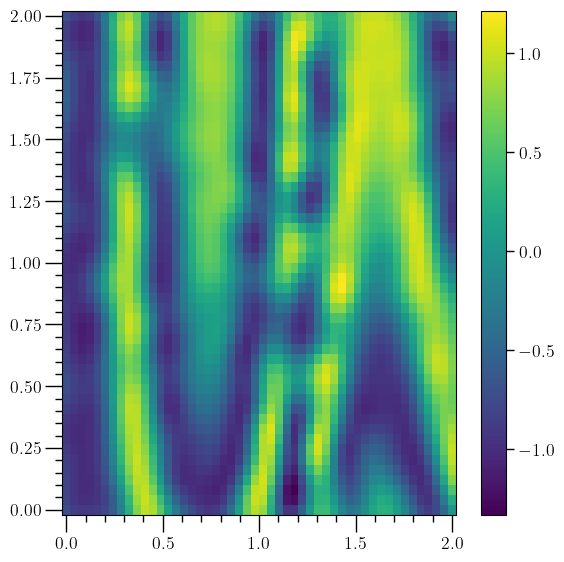

In [13]:
if plots:
    pl.canvas()
    pl.den_plot([t3d,"gp"])
    pl.colbar=True
    plot.show()

Create the neural network interpolation object

In [14]:
im2=o2sclpy.interpm_tf_dnn()
print(' ')

Train the neural network, but capture the output

In [15]:
with io.capture_output() as cap:
    im2.set_data(x2,y2,verbose=1,epochs=2000,
                 transform='none',test_size=0.0,
                 activations=['relu','relu','relu','relu'],
                 hlayers=[256,128,64,16])

2024-03-27 22:39:53.731865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Summarize the end of the training output

In [16]:
print('')
lines1=cap.stdout.split('\n')
for line in lines1[-10:]:
    print(line)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021     
Epoch 1997/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017     
Epoch 1998/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 
Epoch 1999/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 
Epoch 2000/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 



Use the neural network to fill the plane of data. This step takes a
few minutes.

In [17]:
if t3d.is_slice("nn")[0]==False:
    t3d.new_slice("nn")
t3d.set_slice_all("nn",0.0)
for i in range(0,t3d.get_nx()):
    for j in range(0,t3d.get_ny()):
        x=t3d.get_grid_x(i)
        y=t3d.get_grid_y(j)
        with io.capture_output() as cap:
            t3d.set(i,j,"nn",im2.eval(numpy.array([x,y])));
    if i%2==1:
        print('i:',i+1,'/',t3d.get_nx())

i: 2 / 50
i: 4 / 50
i: 6 / 50
i: 8 / 50
i: 10 / 50
i: 12 / 50
i: 14 / 50
i: 16 / 50
i: 18 / 50
i: 20 / 50
i: 22 / 50
i: 24 / 50
i: 26 / 50
i: 28 / 50
i: 30 / 50
i: 32 / 50
i: 34 / 50
i: 36 / 50
i: 38 / 50
i: 40 / 50
i: 42 / 50
i: 44 / 50
i: 46 / 50
i: 48 / 50
i: 50 / 50


Make a comparison plot

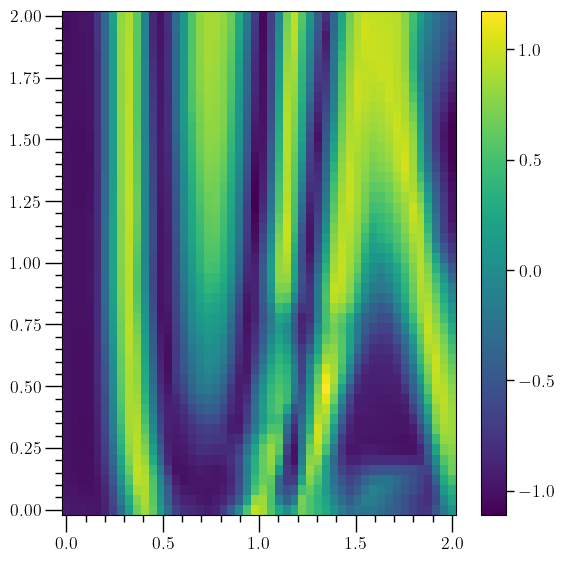

In [18]:
if plots:
    pl.canvas()
    pl.den_plot([t3d,"nn"])
    pl.colbar=True
    plot.show()

Now perform a quantitative comparison of the performance of the
Gaussian process and the neural network and compare them. This is
not a complete or "fair" comparison.

In [19]:
gpt=0
nnt=0
for i in range(0,t3d.get_nx()):
    for j in range(0,t3d.get_ny()):
        gpt=gpt+numpy.abs(t3d.get(i,j,"z")-t3d.get(i,j,"gp"))
        nnt=nnt+numpy.abs(t3d.get(i,j,"z")-t3d.get(i,j,"nn"))

In [20]:
print('')
print('Gaussian proces:',gpt,'neural network:',nnt)


Gaussian proces: 336.82078791746596 neural network: 217.56559082409066
